<a href="https://colab.research.google.com/github/rodjfg/los-fabulosos-pixelotls/blob/master/glm_together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Left / Right model

In [1]:
!pip install --quiet git+https://github.com/rodjfg/los-fabulosos-pixelotls

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\apalaci\AppData\Local\Continuum\miniconda3\envs\pixelotls\lib\site-packages\pip\_internal\cli\base_command.py", line 180, in _main
    status = self.run(options, args)
  File "C:\Users\apalaci\AppData\Local\Continuum\miniconda3\envs\pixelotls\lib\site-packages\pip\_internal\cli\req_command.py", line 205, in wrapper
    return func(self, options, args)
  File "C:\Users\apalaci\AppData\Local\Continuum\miniconda3\envs\pixelotls\lib\site-packages\pip\_internal\commands\install.py", line 393, in run
    installed = install_given_reqs(
  File "C:\Users\apalaci\AppData\Local\Continuum\miniconda3\envs\pixelotls\lib\site-packages\pip\_internal\req\__init__.py", line 70, in install_given_reqs
    uninstalled_pathset = requirement.uninstall(
  File "C:\Users\apalaci\AppData\Local\Continuum\miniconda3\envs\pixelotls\lib\site-packages\pip\_internal\req\req_install.py", line 657, in uninstall
    uninstalled_pathset = UninstallPat

In [6]:
from los_fabulosos_pixelotls.tools import load_raw_data, select_by_areas, select_by_contrast, select_trials, calculate_mean_firing_rate, select_by_response
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import itertools
from los_fabulosos_pixelotls.analysis_tool import clasificator_analisis

rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
# get data
alldat = load_raw_data('../dat')

In [50]:
def get_samples(alldat, selected_regions = ["VISp"], gaussfilter = True, gauss_sigma = 1, y_window = np.arange(250), contrast_list=None, normalize='zscore', balance=False):

  if not contrast_list:
    contrast_list = [x for x in itertools.permutations([0,0.25,0.5,1], 2)]
  elif contrast_list == 'right_stimulus':
    contrast_list = [x for x in itertools.permutations([0,0.25,0.5,1], 2) if x[0] < x[1]]
  elif contrast_list == 'left_stimulus':
    contrast_list = [x for x in itertools.permutations([0,0.25,0.5,1], 2) if x[0] > x[1]]

  samples = np.empty((0,len(y_window)))
  y = np.empty((0,))

  for dat in alldat:
    dt = dat['bin_size']
    neurons_indices_in_area = select_by_areas(dat, selected_regions = selected_regions)

    if len(neurons_indices_in_area) > 0:
      mean_activity = np.mean(dat['spks'][neurons_indices_in_area] / dt, axis=(0,1,2))
      std_activity = np.std(dat['spks'][neurons_indices_in_area] / dt, axis=(0,1,2))

      for contrast in contrast_list:
        right_response_trials = select_trials(dat, contrast_pair=contrast, response_type = 'to_left') # trials in which mouse should move to the left (higher contrast on right side)
        left_response_trials = select_trials(dat, contrast_pair=contrast, response_type = 'to_right') # trials in which mouse should move to the right (higher contrast on left side)

        # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the left
        right_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,right_response_trials][...,y_window], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)
        # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the right
        left_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,left_response_trials][...,y_window], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)

        if normalize == 'div_by_mean':
          right_firing_rates=right_firing_rates/mean_activity
          left_firing_rates=left_firing_rates/mean_activity
        elif normalize == 'zscore':
          right_firing_rates=(right_firing_rates-mean_activity)/std_activity
          left_firing_rates=(left_firing_rates-mean_activity)/std_activity

        # find minimum number of samples that can be extracted from both conditions
        # 1: mouse moved to the left, 0: mouse moved to the right
        if balance:
          n_min = min(right_firing_rates.shape[0],left_firing_rates.shape[0])
          samples = np.concatenate((samples,right_firing_rates[:n_min,...]),axis=0)
          samples = np.concatenate((samples,left_firing_rates[:n_min,...]),axis=0)
          y = np.concatenate( (y, np.ones(n_min)) )
          y = np.concatenate( (y, np.zeros(n_min)) )
        else:
          samples = np.concatenate((samples,right_firing_rates),axis=0)
          samples = np.concatenate((samples,left_firing_rates),axis=0)
          y = np.concatenate( (y, np.ones(right_firing_rates.shape[0])) )
          y = np.concatenate( (y, np.zeros(left_firing_rates.shape[0])) )

  return samples, y

def plot_regions_results(regions_of_interest,model_test_score):
    nmodels = len(model_test_score)
    cmap = get_cmap('Spectral')
    colors = cmap(np.arange(nmodels)/nmodels)
    plt.barh(range(nmodels), model_test_score, color=colors, edgecolor='k', linewidth=0.2)
    plt.yticks(range(nmodels),regions_of_interest)
    plt.axvline(x=0.5,lw=2,linestyle='--',color='r')
    plt.xlim([0,1])
    plt.show()

def subplot_scores(regions_of_interest,model_test_score,regions_labels,colors,ax=None):
  if ax is None:
    ax=plt.gca()
  nmodels = len(model_test_score)
  ax.barh(range(nmodels), model_test_score, color=colors, edgecolor='k', linewidth=0.2)
  ax.set_yticks(range(nmodels))
  ax.set_yticklabels(regions_labels)
  ax.axvline(x=0.5,lw=2,linestyle='--',color='r')
  ax.set_xlim([0,1])
  ax.set_xlabel('model accuracy')
  ax.set_ylabel('model region')
  ax.set_title('model scores')

def subplot_coefs(regions_of_interest,model_list,regions_labels,y_window,colors,plot_models,rescale,ax=None):
  if ax is None:
    ax=plt.gca()
  nmodels = len(model_list)
  
  all_coefs = []
  for im in range(nmodels):
    all_coefs.append(model_list[im].coef_[0,:])
  all_coefs = np.vstack(all_coefs)
  if rescale:
    all_coefs = all_coefs/np.abs(all_coefs).max()
  
  ax.axhline(y=0,color="k",lw=1)
  for im in plot_models:
    ax.plot(y_window,all_coefs[im,:],color=colors[im], label=regions_labels[im])
  ax.set_xlabel('time (ms)')
  ax.set_ylabel('model coef')
  if rescale:
    ax.set_ylabel('model coef\n(rel. to max amplitude)')
  ax.set_title(f'model coefficients (best {len(plot_models)})')

def plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window=None,regions_labels=None,cmap_name='Spectral',best_n=None,rescale=False,axes=None):
  if regions_labels is None:
    regions_labels = regions_of_interest
  if axes is None:
    fig, axes = plt.subplots(2, 1)
  if y_window is None:
    y_window = np.arange(model_list[0].coef_.shape[1])
  nmodels = len(model_test_score)

  if best_n is None:
    plot_models = np.arange(nmodels)
  else:
    plot_models = np.argsort(model_test_score)[::-1][:best_n]

  cmap = get_cmap(cmap_name)
  colors = cmap(np.arange(nmodels)/nmodels)
  subplot_scores(regions_of_interest,model_test_score,regions_labels,colors,ax=axes[0])
  subplot_coefs(regions_of_interest,model_list,regions_labels,y_window,colors,plot_models,rescale,ax=axes[1])
  plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [43]:
def clasificator_analisis(model, X, y, axes=None, verbose=False):
    '''Compute accuracy with CV, confusion matrix, precision-recall scores and plot ROC and precision-recall curves.
    Args: 
        model = model object trained from sklearn
            X = input features in train or test
            y = target in train or test
    Return:
    Print of all the scores computed and save accuracy, cm, precision, recall
    '''

    from sklearn.model_selection import cross_val_predict, cross_val_score
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix

    if axes is None:
        fig, axes = plt.subplots(3,1)

    accu = cross_val_score(model, X, y, cv=3, scoring="accuracy").mean()
    pred = cross_val_predict(model, X, y, cv=3)
    cm = confusion_matrix(y,pred)
    precision = precision_score(y,pred)
    recall = recall_score(y, pred)
    plot_precision_recall_curve(model, X, y, ax=axes[0])
    
    if verbose:
        print(f'Accuracy:{accu}\n')
        print(f'Confusion Matrix:\n{cm}\n')
        print(f'Precision: {precision}\n')
        print(f'Recall: {recall}')

    plot_roc_curve(model, X, y, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], color='0.5', ls=':')

    plot_confusion_matrix(model, X, y, display_labels=['to Right','to Left'], ax=axes[2])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        
    return accu, cm, precision, recall

## Visual cortex areas loop

In [4]:
regions_of_interest = [["VISa"], ["VISam"], ["VISl"], ["VISp"], ["VISpm"], ["VISrl"], ["VISa","VISam","VISl","VISp","VISpm","VISrl"]]
regions_labels =["VISa","VISam","VISl","VISp","VISpm","VISrl", "vis_cortex"]
results = {}

In [5]:
results = {}
ianalysis = 0

# unbalanced, no filter, 0-1200 window, l2
ianalysis += 1
results[ianalysis] = {}
results[ianalysis]['description'] = 'unbalanced, no filter, 0-1200 window, l2'
y_window=np.arange(0,120)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=False , y_window=y_window)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))

results[ianalysis]['model_list'] = model_list
results[ianalysis]['model_test_score'] = model_test_score
results[ianalysis]['y_window'] = y_window
results[ianalysis]['train_size'] = samples_train.shape[0]

# unbalanced, no filter, 0-1200 window, l1
ianalysis += 1
results[ianalysis] = {}
results[ianalysis]['description'] = 'unbalanced, no filter, 0-1200 window, l1'
y_window=np.arange(0,120)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=False , y_window=y_window)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l1', Cs=10, cv=5, solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))

results[ianalysis]['model_list'] = model_list
results[ianalysis]['model_test_score'] = model_test_score
results[ianalysis]['y_window'] = y_window
results[ianalysis]['train_size'] = samples_train.shape[0]

# unbalanced, filtered, 0-1200 window, l2
ianalysis += 1
results[ianalysis] = {}
results[ianalysis]['description'] = 'unbalanced, filtered, 0-1200 window, l2'
y_window=np.arange(0,120)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=True, y_window=y_window)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))

results[ianalysis]['model_list'] = model_list
results[ianalysis]['model_test_score'] = model_test_score
results[ianalysis]['y_window'] = y_window
results[ianalysis]['train_size'] = samples_train.shape[0]

# unbalanced, no filter, 500-900 window, l2
ianalysis += 1
results[ianalysis] = {}
results[ianalysis]['description'] = 'unbalanced, filtered, 500-900 window, l2'
y_window=np.arange(50,90)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=False, y_window=y_window)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))

results[ianalysis]['model_list'] = model_list
results[ianalysis]['model_test_score'] = model_test_score
results[ianalysis]['y_window'] = y_window
results[ianalysis]['train_size'] = samples_train.shape[0]

# unbalanced LEFT, no filter, 0-1200 window, l2
ianalysis += 1
results[ianalysis] = {}
results[ianalysis]['description'] = 'unbalanced LEFT, no filter, 0-1200 window, l2'
y_window=np.arange(0,120)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=False , y_window=y_window, contrast_list='left_stimulus')
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))

results[ianalysis]['model_list'] = model_list
results[ianalysis]['model_test_score'] = model_test_score
results[ianalysis]['y_window'] = y_window
results[ianalysis]['train_size'] = samples_train.shape[0]

# unbalanced RIGHT, no filter, 0-1200 window, l2
ianalysis += 1
results[ianalysis] = {}
results[ianalysis]['description'] = 'unbalanced RIGHT, no filter, 0-1200 window, l2'
y_window=np.arange(0,120)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=False , y_window=y_window, contrast_list='right_stimulus')
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))

results[ianalysis]['model_list'] = model_list
results[ianalysis]['model_test_score'] = model_test_score
results[ianalysis]['y_window'] = y_window
results[ianalysis]['train_size'] = samples_train.shape[0]

# unbalanced LEFT, no filter, 0-1200 window, l2
ianalysis += 1
results[ianalysis] = {}
results[ianalysis]['description'] = 'balanced LEFT, no filter, 0-1200 window, l2'
y_window=np.arange(0,120)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=False , y_window=y_window, contrast_list='left_stimulus',balance=True)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))

results[ianalysis]['model_list'] = model_list
results[ianalysis]['model_test_score'] = model_test_score
results[ianalysis]['y_window'] = y_window
results[ianalysis]['train_size'] = samples_train.shape[0]

# unbalanced RIGHT, no filter, 0-1200 window, l2
ianalysis += 1
results[ianalysis] = {}
results[ianalysis]['description'] = 'balanced RIGHT, no filter, 0-1200 window, l2'
y_window=np.arange(0,120)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=False , y_window=y_window, contrast_list='right_stimulus',balance=True)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))

results[ianalysis]['model_list'] = model_list
results[ianalysis]['model_test_score'] = model_test_score
results[ianalysis]['y_window'] = y_window
results[ianalysis]['train_size'] = samples_train.shape[0]

C:\Users\apalaci\AppData\Local\Continuum\miniconda3\envs\pixelotls\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


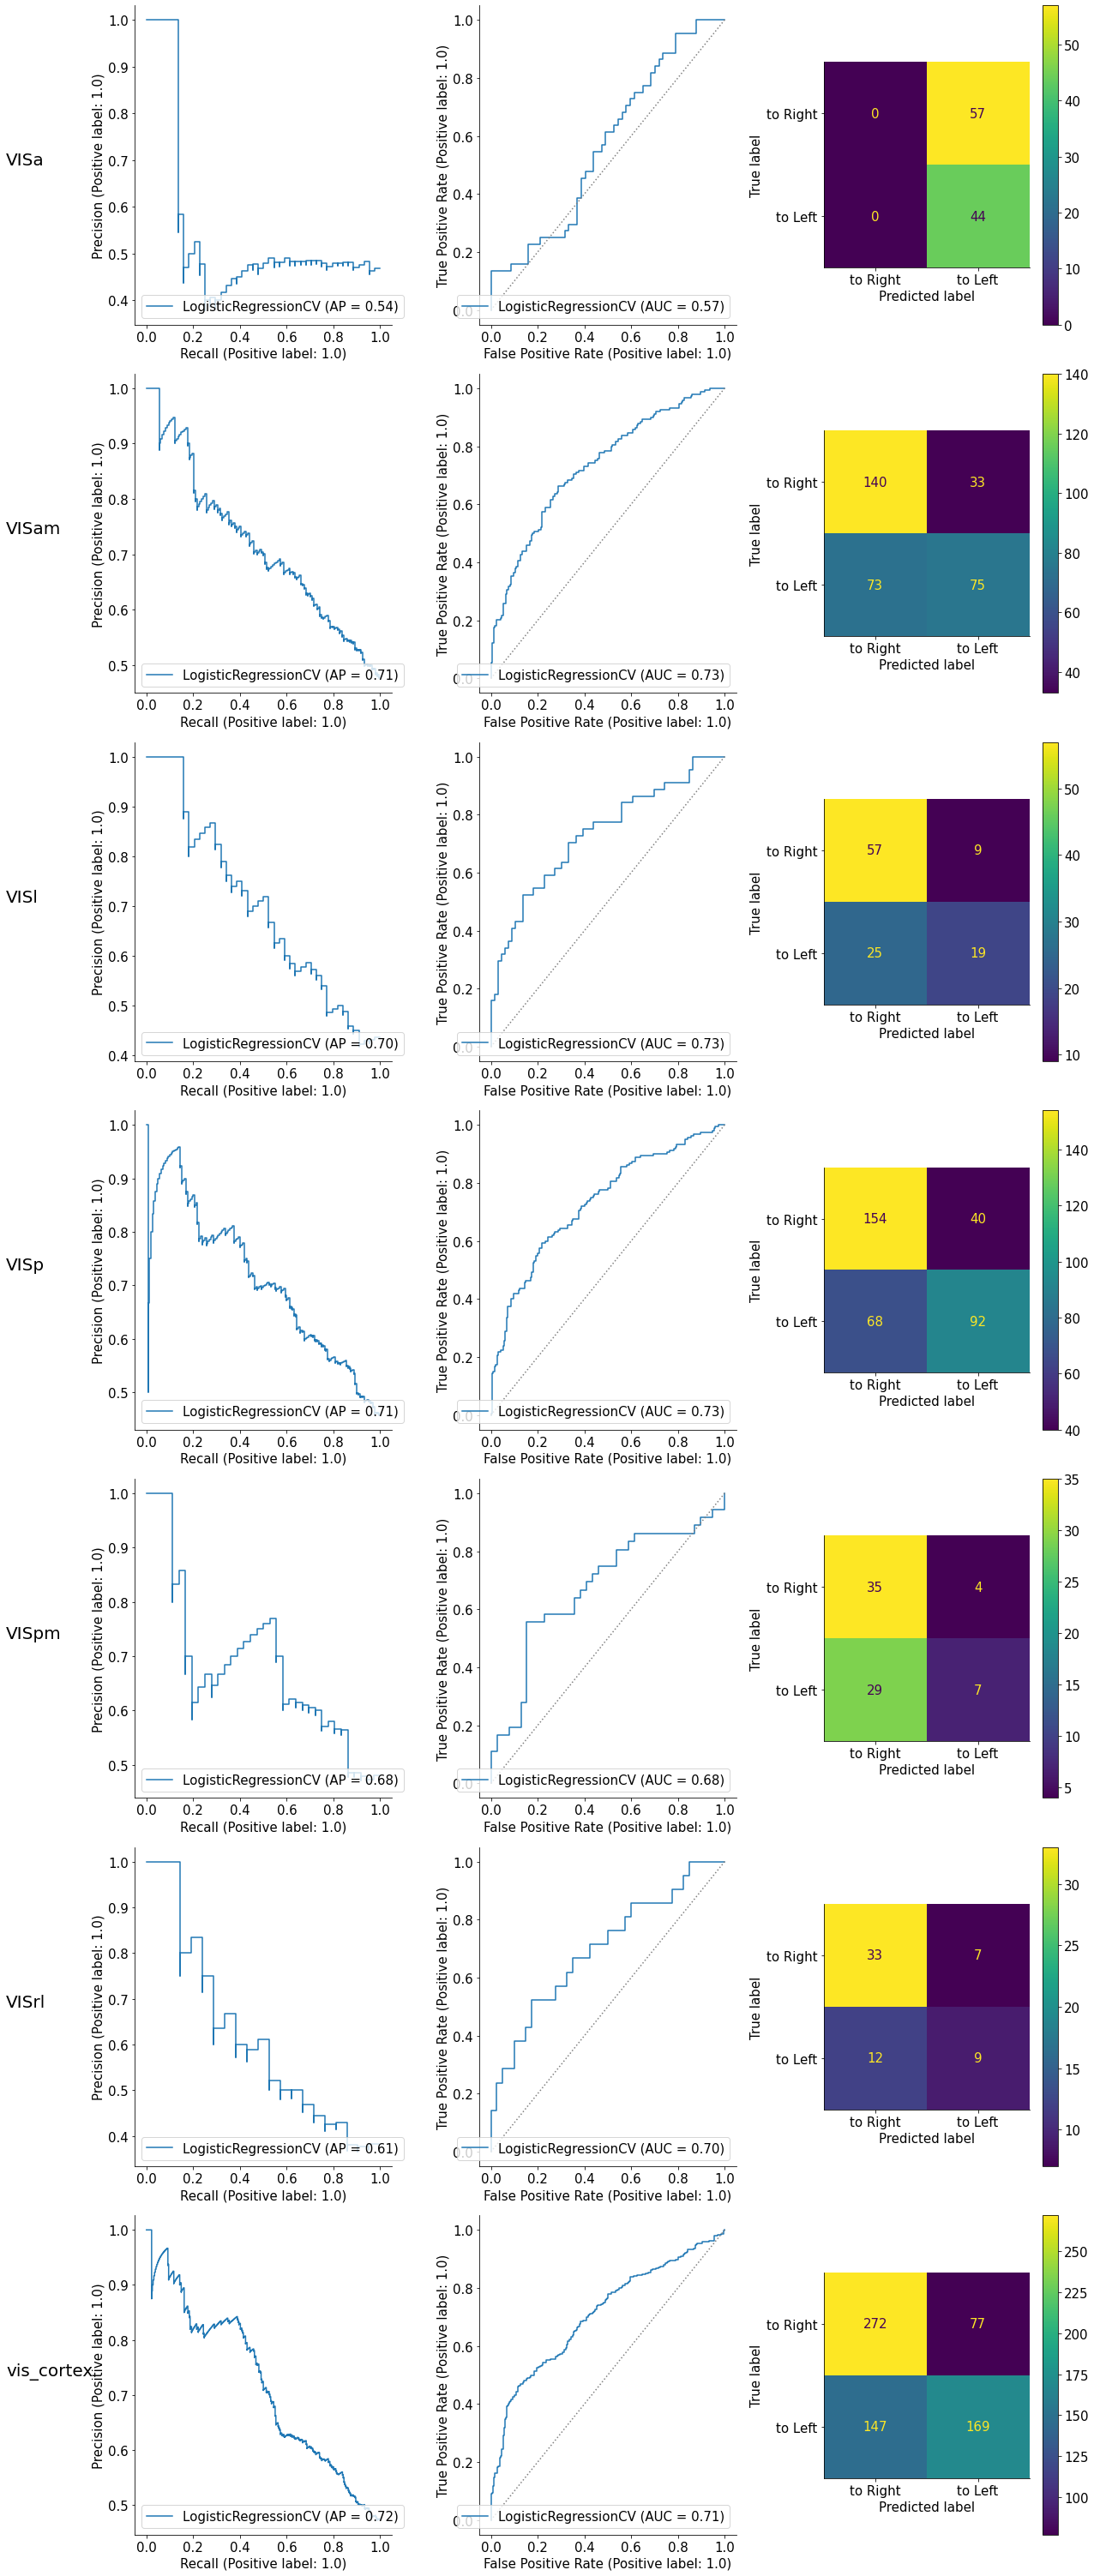

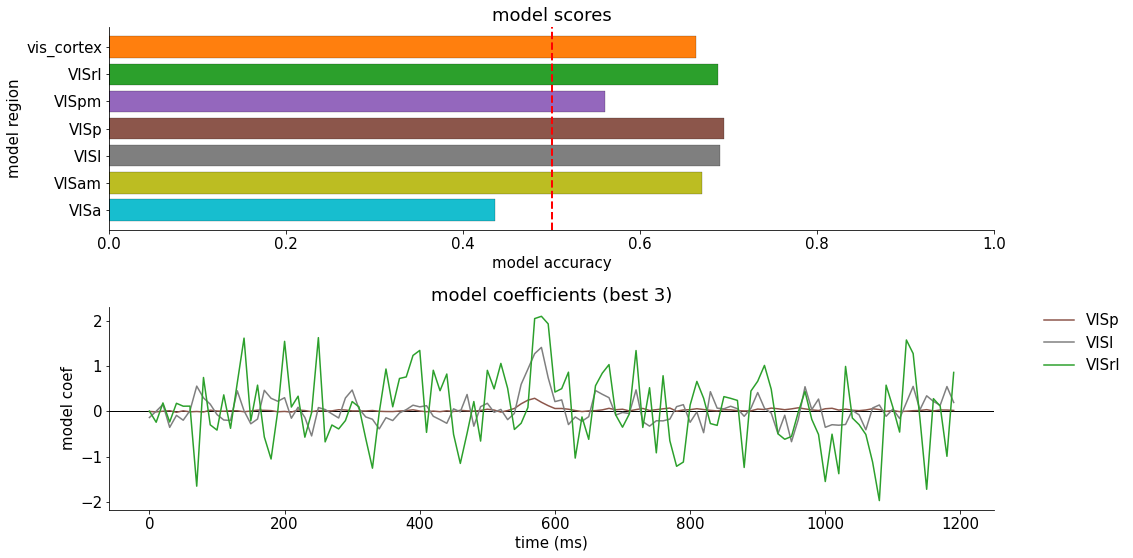

In [70]:
y_window=np.arange(0,120)

nrows, ncols = (len(regions_of_interest),3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

model_list = []
model_test_score = []
for ii, region in enumerate(regions_of_interest):
    region_label = regions_labels[ii]
    samples, y = get_samples(alldat, region, gaussfilter=False , y_window=y_window, contrast_list=None,balance=False)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
    accu, cm, precision, recall = clasificator_analisis(clf, samples_test, y_test, axes=axes[ii,:])
    axes[ii,0].text(-0.5,0.5,region_label,transform=axes[ii,0].transAxes,fontsize=20)
plt.show()

nrows, ncols = (2,1)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16*ncols, 4*nrows))
axes = axes.flatten()
plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window*10,regions_labels,'tab10_r',3,False,axes)
plt.subplots_adjust(hspace=0.4)
plt.show()

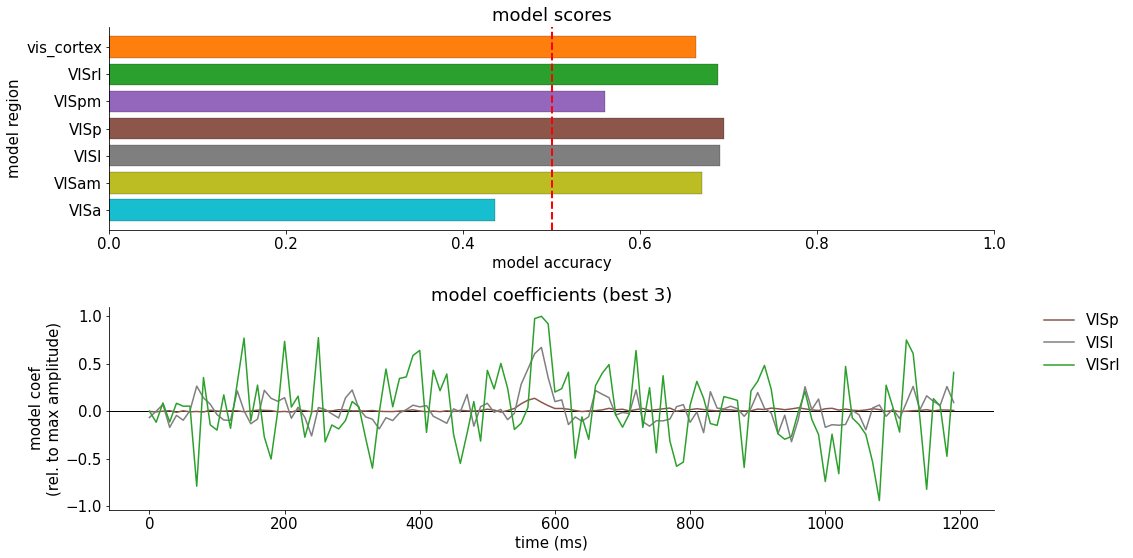

In [72]:
nrows, ncols = (2,1)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16*ncols, 4*nrows))
axes = axes.flatten()
plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window*10,regions_labels,'tab10_r',3,rescale = True,axes=axes)
plt.subplots_adjust(hspace=0.4)
plt.show()

In [59]:
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
# sss.get_n_splits(samples, y)
# for train_index, test_index in sss.split(samples, y):
#     #  print("TRAIN:", train_index, "TEST:", test_index)
#      X_train, X_test = samples[train_index], samples[test_index]
#      y_train, y_test = y[train_index], y[test_index]
#      print(np.sum(y_train)/y_train.shape[0], np.sum(y_test)/y_test.shape[0])
# samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(samples, y, test_size=0.5, random_state=42, stratify=y)
print(np.sum(y_train)/y_train.shape[0], np.sum(y_test)/y_test.shape[0])

0.8993939393939394 0.8995157384987893


In [65]:
test_size = 0.5
nsamples = len(y)
ntest = int(test_size*nsamples)
print(y.shape)
print(y.nonzero()[0].shape)

(1651,)
(1485,)


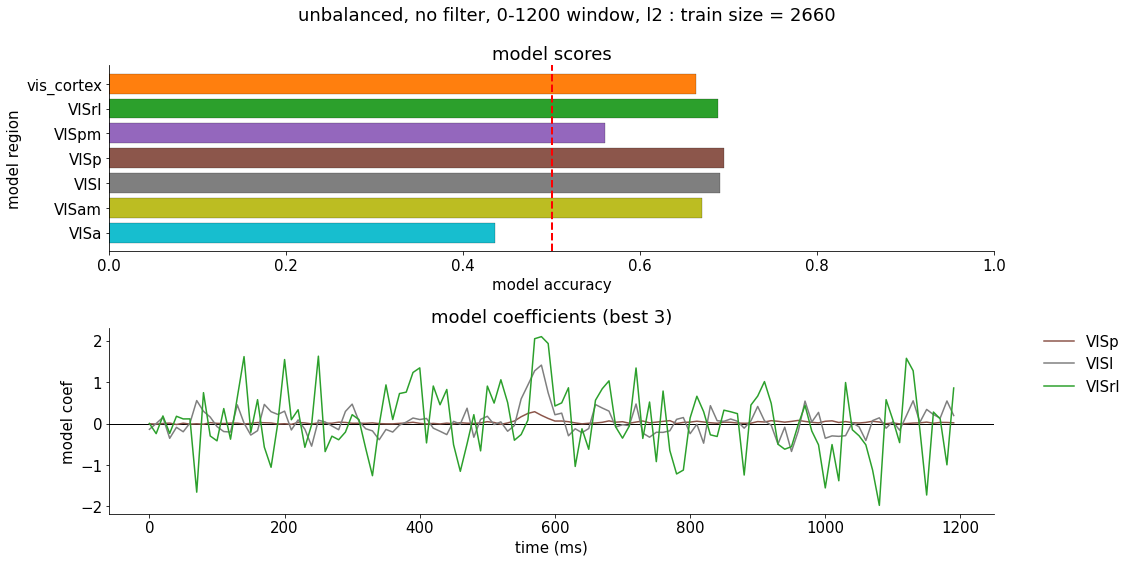

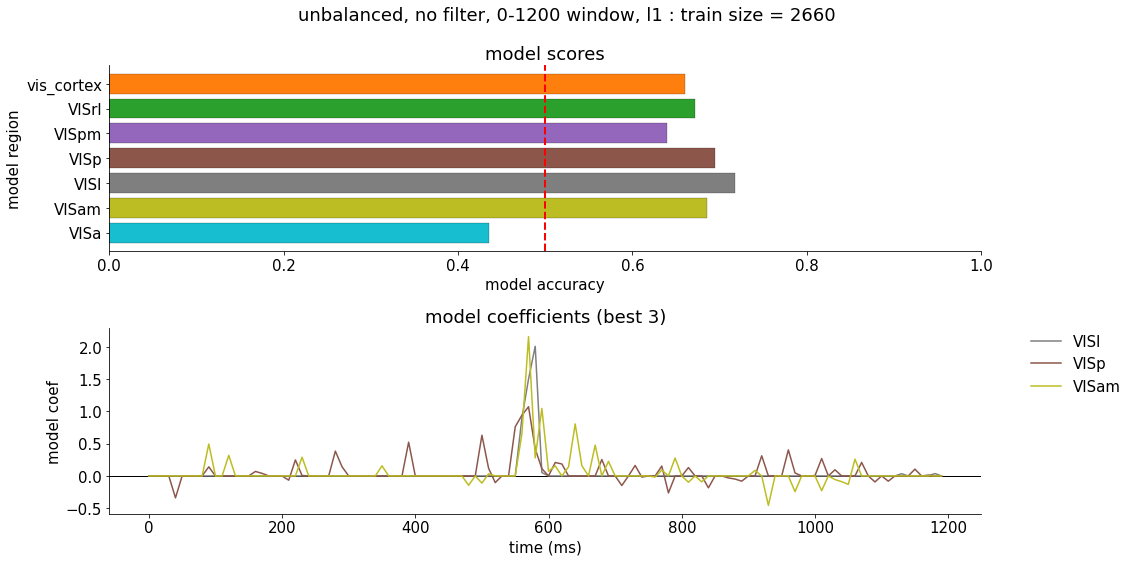

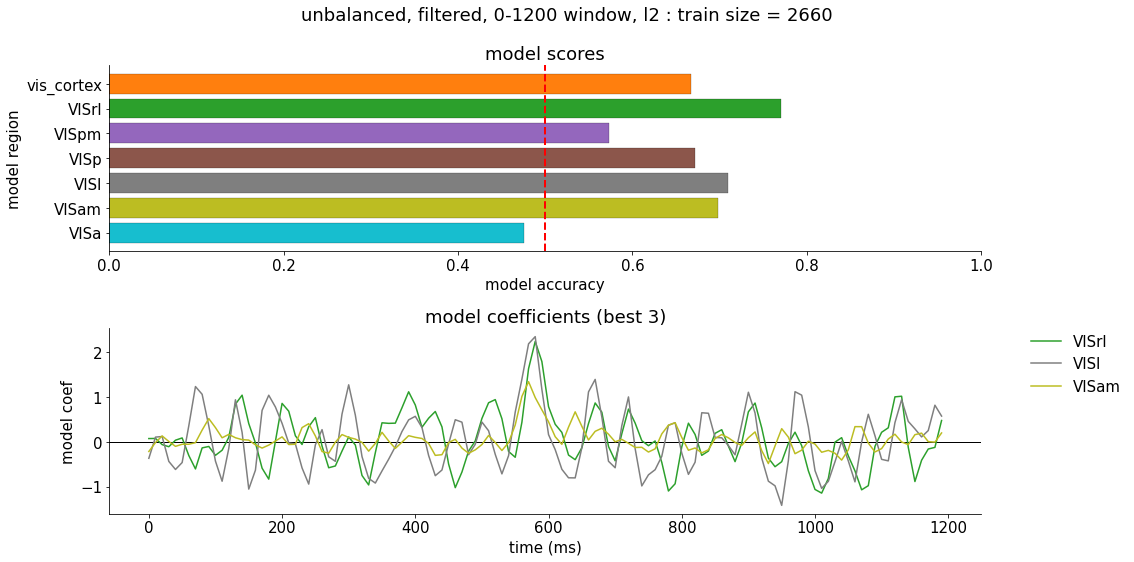

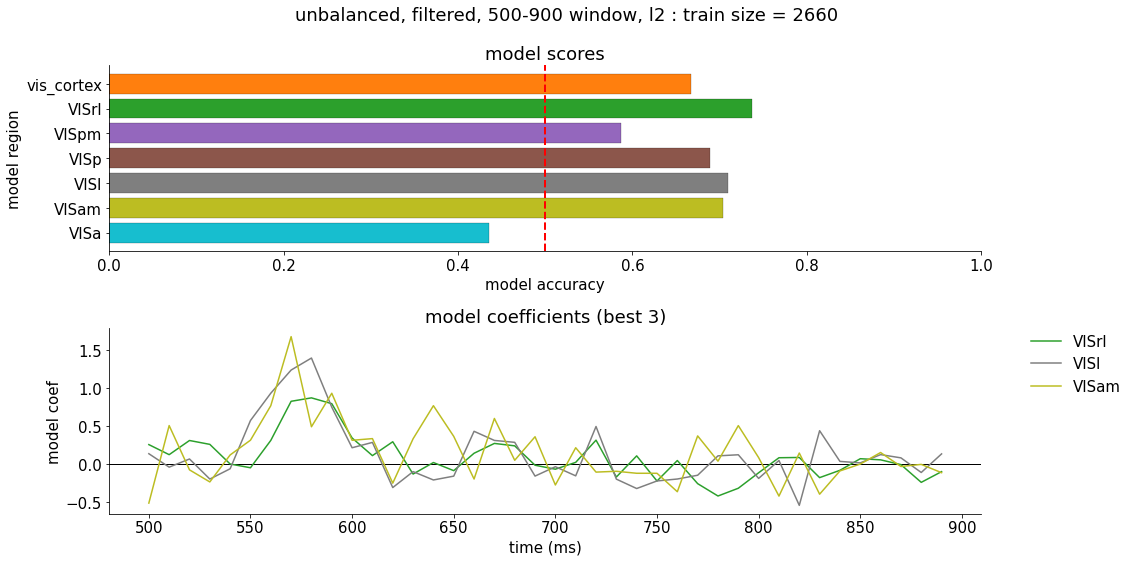

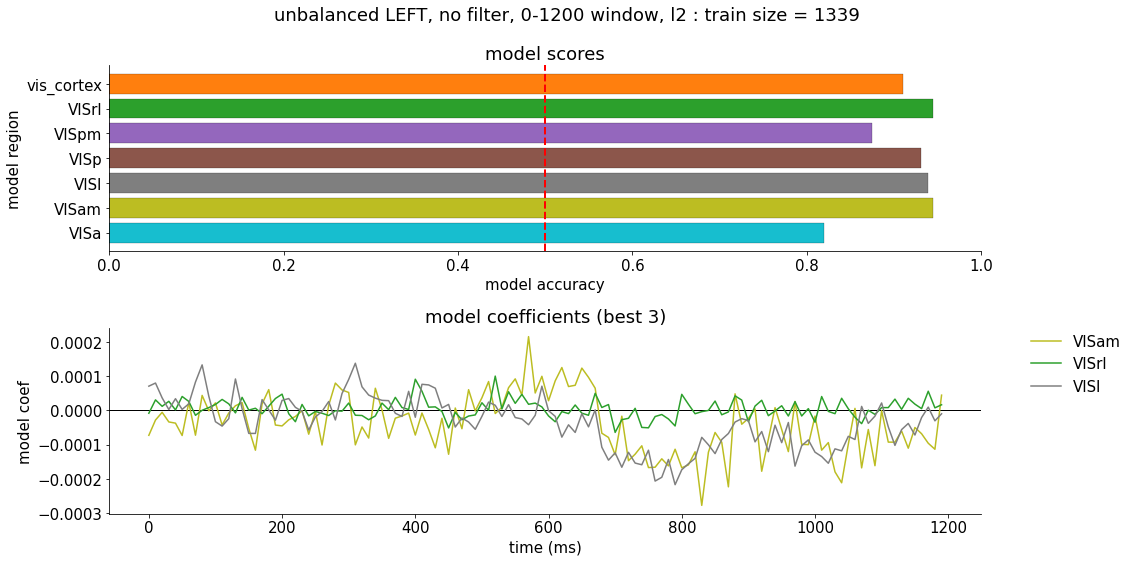

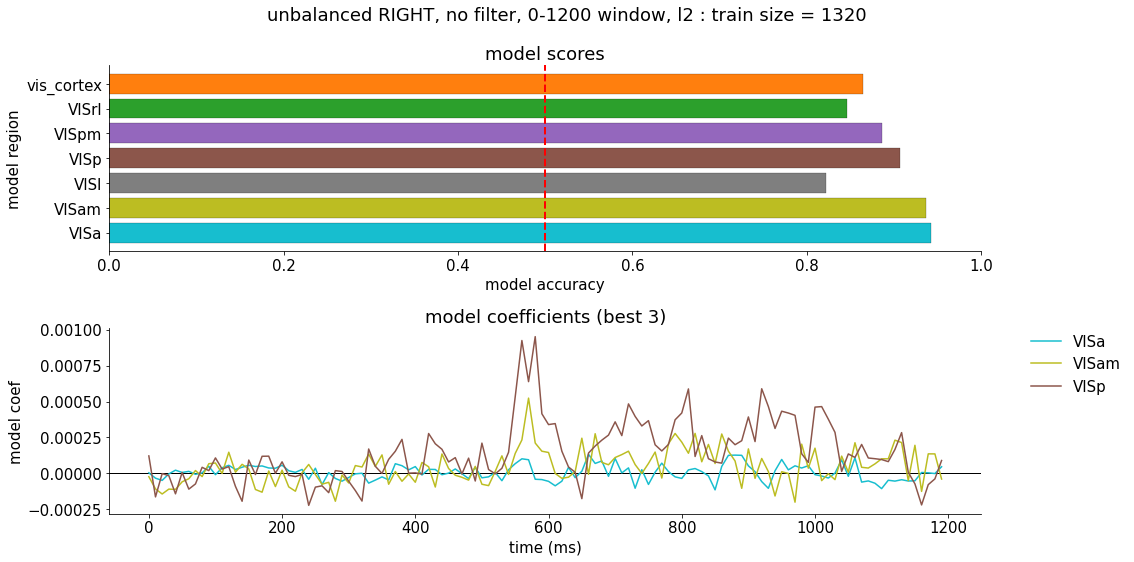

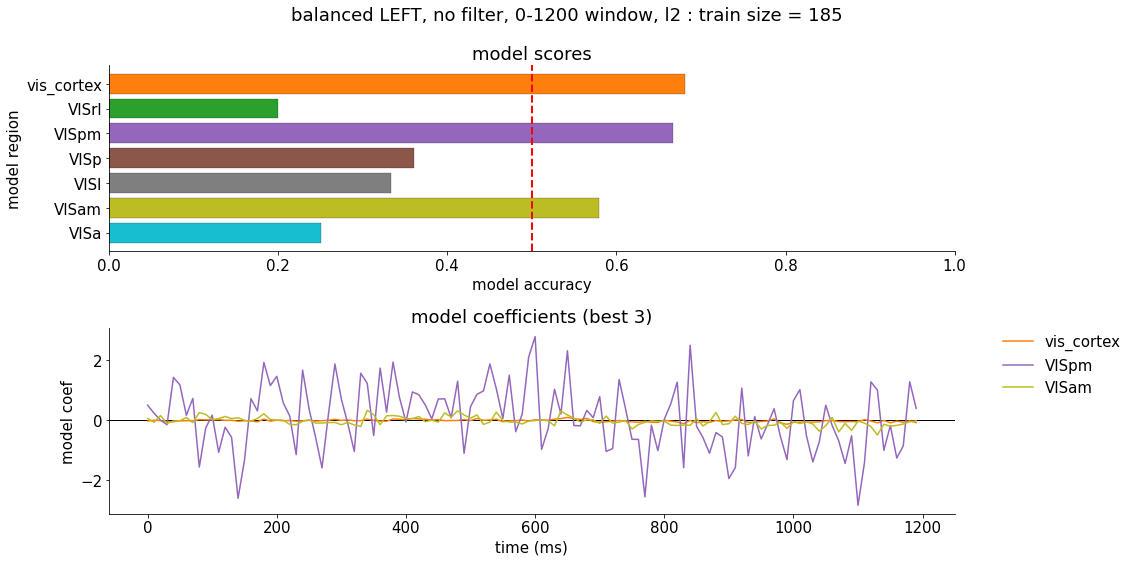

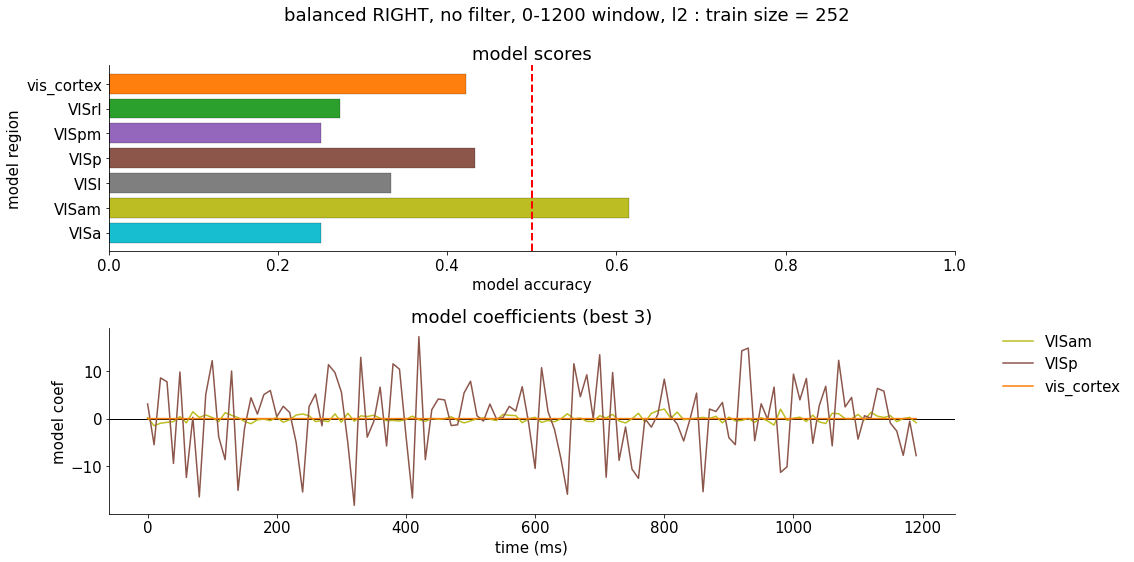

In [17]:
for rs in results.values():
    model_list = rs['model_list']
    train_size = rs['train_size']
    model_test_score = rs['model_test_score']
    y_window = rs['y_window']
    description = rs['description']

    nrows, ncols = (2,1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16*ncols, 4*nrows))
    axes = axes.flatten()
    plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window*10,regions_labels,'tab10_r',3,False,axes)
    plt.suptitle(f'{description} : train size = {train_size}')
    plt.subplots_adjust(hspace=0.4)
    plt.show()

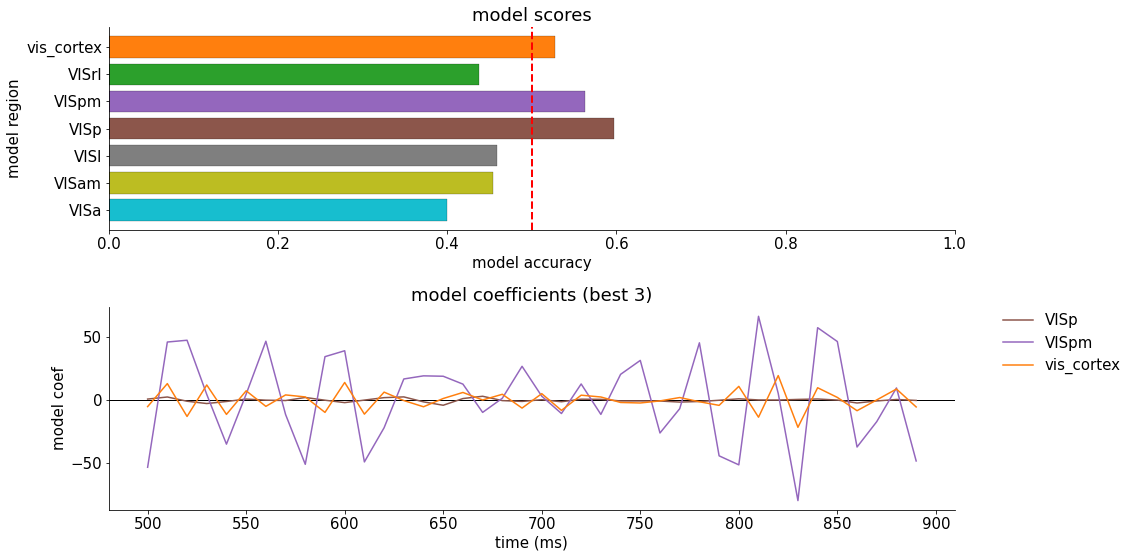

In [19]:
y_window=np.arange(50,90)

model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat, region, gaussfilter=True, y_window=y_window, balance=True)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    # print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))


nrows, ncols = (2,1)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16*ncols, 4*nrows))
axes = axes.flatten()
plot_results_subplots(regions_of_interest,model_list,model_test_score,y_window*10,regions_labels,'tab10_r',3,False,axes)
# plt.suptitle(f'{description} : train size = {train_size}')
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
clasificator_analisis

## Smaller window around second peak

['VISa']: C 0.0001, train 0.51, test 0.48
['VISam']: C 2.782559402207126, train 0.69, test 0.57
['VISl']: C 0.0001, train 0.52, test 0.43
['VISp']: C 0.005994842503189409, train 0.60, test 0.54
['VISpm']: C 21.54434690031882, train 0.89, test 0.68
['VISrl']: C 10000.0, train 0.83, test 0.33


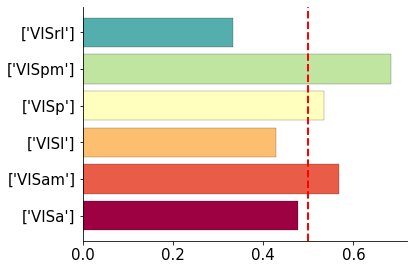

In [22]:
model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat,region,y_window=np.arange(60,90))
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=3, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results(regions_of_interest,model_test_score)

## Dumb model with window before stimulus

['VISa']: C 2.782559402207126, train 0.84, test 0.48
['VISam']: C 166.81005372000558, train 0.76, test 0.39
['VISl']: C 166.81005372000558, train 0.80, test 0.32
['VISp']: C 0.005994842503189409, train 0.63, test 0.49
['VISpm']: C 0.000774263682681127, train 0.52, test 0.63
['VISrl']: C 0.046415888336127774, train 0.75, test 0.44


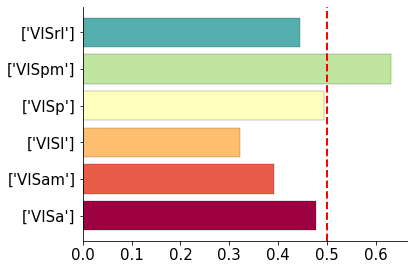

In [23]:
model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat,region,y_window=np.arange(0,50))
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=3, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results(regions_of_interest,model_test_score)

## Full window, extremely smoothed

['VISa']: C 0.046415888336127774, train 0.73, test 0.43
['VISam']: C 0.0001, train 0.56, test 0.35
['VISl']: C 0.0001, train 0.52, test 0.43
['VISp']: C 0.000774263682681127, train 0.61, test 0.52
['VISpm']: C 0.046415888336127774, train 0.72, test 0.53
['VISrl']: C 0.0001, train 0.52, test 0.44


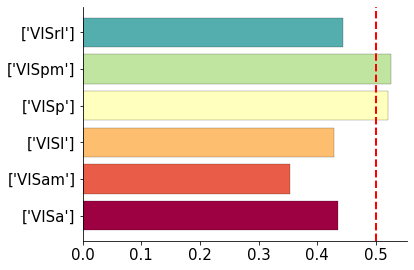

In [24]:
model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat,region,gauss_sigma=5)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=3, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results(regions_of_interest,model_test_score)

## Full window, no smoothing

['VISa']: C 0.0001, train 0.75, test 0.57
['VISam']: C 0.0001, train 0.73, test 0.35
['VISl']: C 0.0001, train 0.60, test 0.43
['VISp']: C 0.0001, train 0.73, test 0.52
['VISpm']: C 0.046415888336127774, train 1.00, test 0.68
['VISrl']: C 0.0001, train 0.52, test 0.44


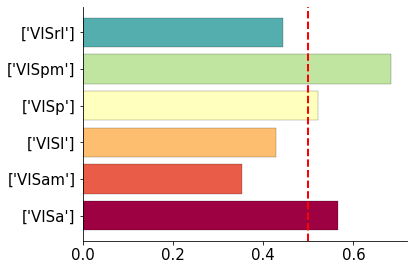

In [25]:
model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat,region,gaussfilter=False)
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=3, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results(regions_of_interest,model_test_score)

## Only for stimuli stronger on one side

## ... Right stimulus stronger than Left

['VISa']: C 0.005994842503189409, train 0.93, test 0.12
['VISam']: C 0.000774263682681127, train 0.75, test 0.65
['VISl']: C 0.0001, train 0.54, test 0.33
['VISp']: C 21.54434690031882, train 1.00, test 0.51
['VISpm']: C 0.005994842503189409, train 0.86, test 0.38
['VISrl']: C 2.782559402207126, train 1.00, test 0.55


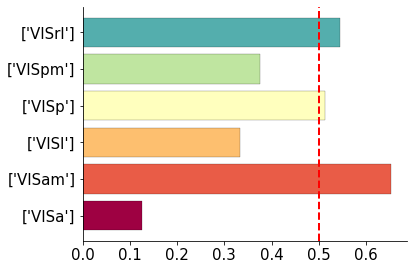

In [26]:
model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat,region, contrast_list='right_stimulus')
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=3, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results(regions_of_interest,model_test_score)

['VISa']: C 0.005994842503189409, train 0.57, test 0.25
['VISam']: C 0.046415888336127774, train 0.67, test 0.69
['VISl']: C 0.0001, train 0.54, test 0.33
['VISp']: C 0.0001, train 0.50, test 0.49
['VISpm']: C 0.046415888336127774, train 0.57, test 0.25
['VISrl']: C 2.782559402207126, train 1.00, test 0.64


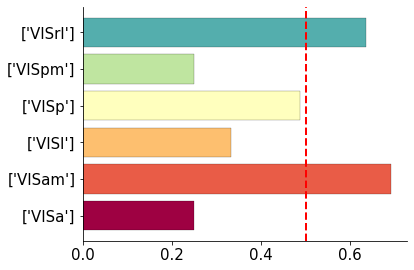

In [28]:
model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat,region, contrast_list='right_stimulus')
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l1', Cs=10, cv=3, solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results(regions_of_interest,model_test_score)

## ... Left stimulus stronger than Right

['VISa']: C 0.0001, train 0.56, test 0.25
['VISam']: C 0.000774263682681127, train 0.75, test 0.47
['VISl']: C 0.005994842503189409, train 1.00, test 0.67
['VISp']: C 0.000774263682681127, train 0.67, test 0.36
['VISpm']: C 0.3593813663804626, train 1.00, test 0.78
['VISrl']: C 21.54434690031882, train 1.00, test 0.20


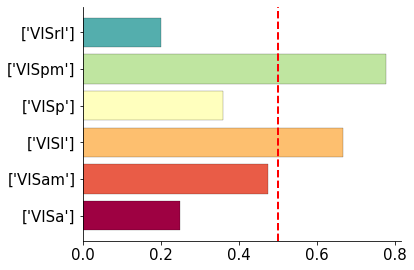

In [27]:
model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat,region, contrast_list='left_stimulus')
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=3, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results(regions_of_interest,model_test_score)

['VISa']: C 0.046415888336127774, train 0.56, test 0.25
['VISam']: C 21.54434690031882, train 1.00, test 0.47
['VISl']: C 0.3593813663804626, train 0.97, test 0.56
['VISp']: C 2.782559402207126, train 1.00, test 0.44
['VISpm']: C 21.54434690031882, train 1.00, test 0.67
['VISrl']: C 0.0001, train 0.58, test 0.20


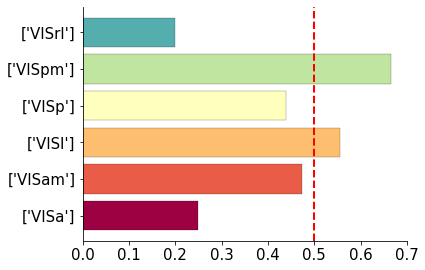

In [29]:
model_list = []
model_test_score = []
for region in regions_of_interest:
    samples, y = get_samples(alldat,region, contrast_list='left_stimulus')
    samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
    clf = LogisticRegressionCV(penalty='l1', Cs=10, cv=3, solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
    print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
    model_list.append(clf)
    model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results(regions_of_interest,model_test_score)

## Full data, full vis cortex

In [10]:
model_list = []
model_test_score = []
samples, y = get_samples(alldat,["VISa","VISam","VISl","VISp","VISpm","VISrl"], contrast_list='right_stimulus')
samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.2, random_state=42)
clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=3, solver='sag', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
print(f'{region}: C {clf.C_[0]}, train {clf.score(samples_train,y_train):.2f}, test {clf.score(samples_test,y_test):.2f}')
model_list.append(clf)
model_test_score.append(clf.score(samples_test,y_test))
plot_regions_results([["VISa","VISam","VISl","VISp","VISpm","VISrl"]],model_test_score)

VISam: C 0.0001, train 0.91, test 0.86


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (6).

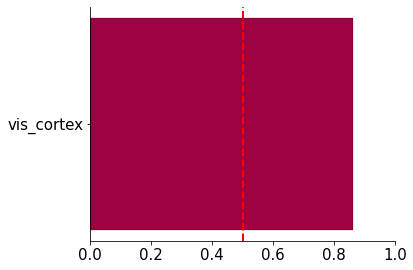

In [14]:
plot_regions_results(['vis_cortex'],model_test_score)